# Математика - Домашнее задание 11

**Дедлайн:** 23:59, 17 февраля  

## Задание

1. По аналогии с реализацией GD и SGD реализуйте метод инерции (Momentum), RMSprop и Adam.  

2. Для произвольной задачи (можно сгенерировать синтетически матрицу $X$ и вектор $y$) сравните результаты работы трех методов оптимизации.  

3. Проведите эксперименты с этими методами для задач разных размерностей, сравните оценки сходимости и сделайте выводы по эмпирическим результатам о скорости и точности сходимости в зависимости от размерности и параметров моделей.  

### Критерии зачета:
- **Зачет на 4**: реализованы 2 из 3 методов  
- **Зачет на 5**: реализованы все методы  


### 1. По аналогии с реализацией GD и SGD реализуйте метод инерции (Momentum), RMSprop и Adam.  

### 2. Для произвольной задачи (можно сгенерировать синтетически матрицу $X$ и вектор $y$) сравните результаты работы трех методов оптимизации.

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

sns.set_palette(palette="Reds")

#### Генерация данных для тестов:

In [130]:
n, m = 500, 2

w_true = np.random.standard_normal(m)

X = np.random.uniform(-5, 5, (n, m))
X *= (np.arange(m) * 2 + 1)[np.newaxis, :]

y = X.dot(w_true) + np.random.normal(0, 1, (n))

Изобразим на графике данные для обучения.

По осям x и y наши два признака, а цвет обозначает величину таргета.

[Text(0.5, 0, 'X[0]'), Text(0, 0.5, 'X[1]')]

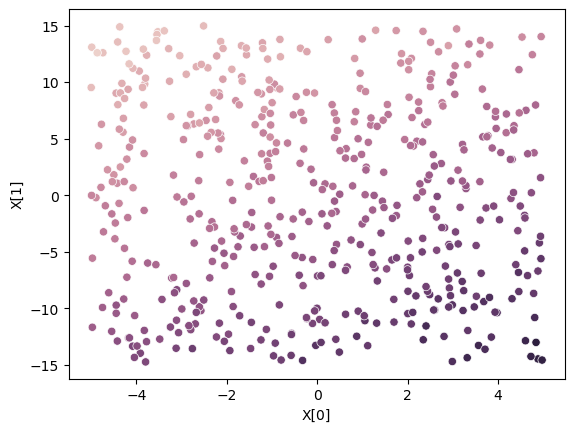

In [132]:
g = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
g.legend_.remove()
g.set(xlabel="X[0]", ylabel="X[1]")

#### Функция для создания графика уровней линии

In [134]:
def plot_weight_levels(X, y, w_history: np.ndarray):
    w1_vals = np.linspace(min(w_history[:, 0]) - 1, max(w_history[:, 0]) + 1, 100)
    w2_vals = np.linspace(min(w_history[:, 1]) - 1, max(w_history[:, 1]) + 1, 100)
    
    W1, W2 = np.meshgrid(w1_vals, w2_vals)
    J_vals = np.zeros_like(W1)

    for i in range(len(w1_vals)):
        for j in range(len(w2_vals)):
            w_tmp = np.array([W1[i, j], W2[i, j]])
            J_vals[i, j] = np.mean((X.dot(w_tmp) - y) ** 2) / 2

    plt.figure(figsize=(12, 8))
    plt.contour(W1, W2, J_vals, levels=30, cmap='viridis')

    # w_history = w_history[w_history[:, 0].argsort()[::-1]]
    print(w_history[-1])
    plt.scatter(w_history[-1][0], w_history[-1][1], marker='*', s=200, color='black', label='Final Point')

    plt.plot(w_history[:, 0], w_history[:, 1], marker='o', linestyle='-', color='red', label='Gradient Descent Trajectory')

    plt.title('Weight Levels and Gradient Descent Trajectory')
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.legend()
    plt.show()

### Давайте для начала посмотрим на стандартный Gradient Descent

In [136]:
def gradient_descent(
    steps: int, 
    alpha: float, 
    X: np.ndarray, 
    y: np.ndarray,
    w = None,
    eps=1,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Функция для оптимизации весов с помощью градиентного спуска

    Args:
        steps (int): количество итераций
        alpha (float): длина шага
        X (np.ndarray): Матрица объектов-признаков
        y (np.ndarray): Вектор таргетов
        w (_type_, optional): Начальное значение для весов. Defaults to None.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Возвращает полученные веса, вектор с историей весов и вектор с ошибками ответов модели на каждой итерации
    """
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)
    print(w)
    w_cur = w.copy()
    w_history = [w_cur]
    err_history = []
    
    for i in range(steps):
        
        y_pred = X.dot(w_cur)  # Ответы с текущими весами
        err = y_pred - y  # Ошибка
        grad = 2 * X.T.dot(err) / n  # Градиент
        if i == 0:
            print(grad)
        if np.sum(grad**2)**0.5 < eps:
            break
        w_cur -= alpha * grad  # Делаем шаг весов в сторону антиградиента

        w_history.append(w_cur.copy())
        err_history.append(err.mean())
    print(w_cur)
    return w_cur, np.array(w_history), np.array(err_history)

[0.29762859 1.08325835]
[-19.04510389 266.34674258]
[ 1.20574899 -0.77573189]
[ 1.20574899 -0.77573189]

[ 1.20574899 -0.77573189]


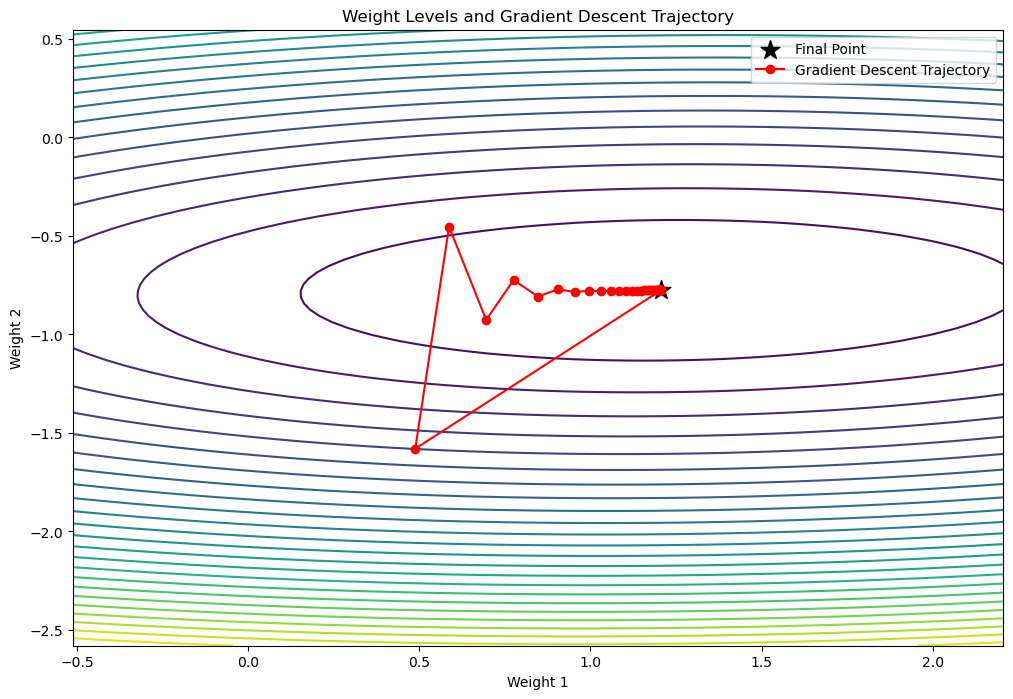

In [137]:
w, w_history, _ = gradient_descent(200, 0.01, X=X, y=y, eps=0.05)
print(w_history[-1])
print()
plot_weight_levels(X, y, w_history)

### Теперь посмотрим на стандартный Stochastic Gradient Descent

In [139]:
def generate_batch(X, y, batch_size):
    """ Генератор для получения батча из данных """
    for i in range(0, len(X), batch_size):
        yield X[i : i + batch_size], y[i : i + batch_size]

In [140]:
def stochastic_gradient_descent(
    epochs: int, 
    batch_size: int, 
    alpha: float, 
    X: np.ndarray, 
    y: np.ndarray, 
    w = None,
    max_iters=1000
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Функция для оптимизации весов с помощью стохастического градиентного спуска

    Args:
        epochs (int): количество эпох
        batch_size (int): размер батча
        alpha (float): длина шага
        X (np.ndarray): Матрица объектов-признаков
        y (np.ndarray): Вектор таргетов
        w (_type_, optional): Начальное значение для вектора весов. Defaults to None.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Возвращает полученные веса, вектор с историей весов и вектор с ошибками ответов модели на каждой итерации
    """
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)

    w_cur = w.copy()
    w_history = [w_cur]
    err_history = []
    n_iter = 0
    for _ in range(epochs):
        p = np.random.permutation(len(X)) # случайно перемешиваем выборку
        batch_generator = generate_batch(X[p], y[p], batch_size)  # инициализируем генератор

        for X_batch, y_batch in batch_generator:  # Итерируемся по полученными батчам
            y_pred = X_batch.dot(w_cur)
            err = y_pred - y_batch
            grad = 2 * X_batch.T.dot(err) / n
            w_cur -= alpha * grad

            w_history.append(w_cur.copy())
            err_history.append(err.mean())
            n_iter += 1
            if n_iter == max_iters:
                 return w, np.array(w_history), np.array(err_history)

    return w, np.array(w_history), np.array(err_history)

[ 0.48924582 -0.12889537]


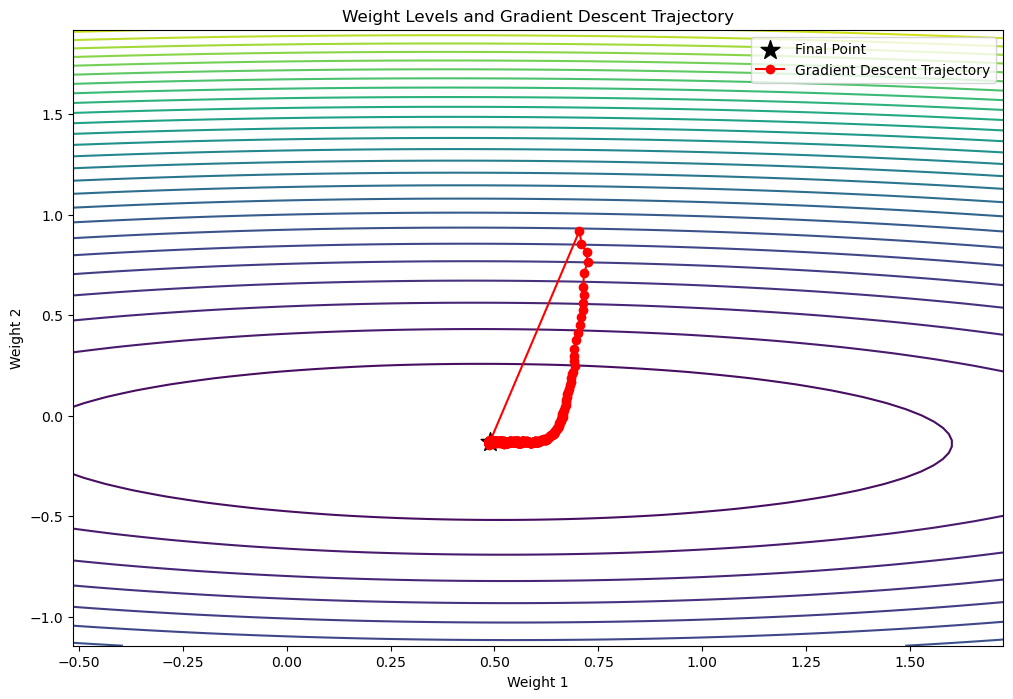

In [141]:
np.random.seed(42)
n, m = 500, 2

w_true = np.random.standard_normal(m)

X = np.random.uniform(-5, 5, (n, m))
X *= (np.arange(m) * 2 + 1)[np.newaxis, :]

y = X.dot(w_true) + np.random.normal(0, 1, (n))
sgd_w, sgd_w_history, _ = stochastic_gradient_descent(100, 20, 1e-2, X, y, max_iters=10000)
plot_weight_levels(X, y, sgd_w_history)

### Реализация метода инерции (Momentum)

In [143]:
def generate_batch(X, y, batch_size):
    """Генератор для получения батча из данных"""
    for i in range(0, len(X), batch_size):
        yield X[i : i + batch_size], y[i : i + batch_size]

def stochastic_gradient_descent_momentum(
    epochs: int, 
    batch_size: int, 
    alpha: float, 
    X: np.ndarray, 
    y: np.ndarray, 
    gamma: float = 0.9,
    w: np.ndarray = None,
    max_iters: int = 1000
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Функция для оптимизации весов с помощью стохастического градиентного спуска с моментумом

    Args:
        epochs (int): количество эпох
        batch_size (int): размер батча
        alpha (float): длина шага
        X (np.ndarray): Матрица объектов-признаков
        y (np.ndarray): Вектор таргетов
        gamma (float): Коэффициент момента (обычно от 0.9 до 0.99)
        w (np.ndarray, optional): Начальное значение для вектора весов. Defaults to None.
        max_iters (int): Максимальное количество итераций

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Возвращает полученные веса, историю весов и ошибки на каждой итерации
    """
    n, m = X.shape

    if w is None:
        w = np.random.standard_normal(m)

    w_cur = w.copy()
    w_history = [w_cur.copy()]
    err_history = []
    velocity = np.zeros_like(w_cur)  # Инициализация скорости - т. е. momentum
    n_iter = 0
    
    for _ in range(epochs):
        p = np.random.permutation(len(X))  # случайно перемешиваем выборку
        batch_generator = generate_batch(X[p], y[p], batch_size)
        
        for X_batch, y_batch in batch_generator:
            y_pred = X_batch.dot(w_cur)
            err = y_pred - y_batch
            grad = 2 * X_batch.T.dot(err) / n
            
            velocity = gamma * velocity + alpha * grad  # бновление скорости
            w_cur -= velocity  # Обновление весов
            
            w_history.append(w_cur.copy())
            err_history.append(err.mean())
            n_iter += 1
            
            if n_iter == max_iters:
                return w_cur, np.array(w_history), np.array(err_history)
    
    return w_cur, np.array(w_history), np.array(err_history)

### Реализация метода RMSprop

In [145]:
def stochastic_gradient_descent_rmsprop(
    epochs: int, 
    batch_size: int, 
    alpha: float, 
    X: np.ndarray, 
    y: np.ndarray, 
    beta: float = 0.9,  # Коэффициент сглаживания
    epsilon: float = 1e-8,  # То самое маленькое число для избежания деления на ноль
    w: np.ndarray = None,
    max_iters: int = 1000
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Функция для оптимизации весов с помощью стохастического градиентного спуска RMSprop

    Args:
        epochs (int): количество эпох
        batch_size (int): размер батча
        alpha (float): длина шага (learning rate)
        X (np.ndarray): Матрица объектов-признаков
        y (np.ndarray): Вектор таргетов
        beta (float): Коэффициент сглаживания (по умолчанию 0.9)
        epsilon (float): Маленькое число для избежания деления на ноль (по умолчанию 1e-8)
        w (np.ndarray, optional): Начальное значение для вектора весов. Defaults to None.
        max_iters (int): Максимальное количество итераций

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: 
            - Итоговые веса
            - История весов
            - Ошибки на каждой итерации
    """
    n, m = X.shape

    if w is None:
        w = np.random.standard_normal(m)

    w_cur = w.copy()
    w_history = [w_cur.copy()]
    err_history = []
    n_iter = 0

    E_grad2 = np.zeros_like(w_cur)  # Инициализация экспоненциального среднего квадрата градиента

    for _ in range(epochs):
        p = np.random.permutation(n)  # Перемешиваем индексы
        batch_generator = generate_batch(X[p], y[p], batch_size)

        for X_batch, y_batch in batch_generator:
            y_pred = X_batch.dot(w_cur)
            err = y_pred - y_batch
            grad = 2 * X_batch.T.dot(err) / n  # Сам радиент

            # RMSprop: обновляем E[grad^2] (скользящее среднее квадрата градиента)
            E_grad2 = beta * E_grad2 + (1 - beta) * grad**2

            # Обновление весов
            w_cur -= alpha * grad / (np.sqrt(E_grad2) + epsilon)

            w_history.append(w_cur.copy())
            err_history.append(err.mean())
            n_iter += 1

            if n_iter == max_iters:
                return w_cur, np.array(w_history), np.array(err_history)

    return w_cur, np.array(w_history), np.array(err_history)

### Реализация метода Adam

In [147]:
def generate_batch(X, y, batch_size):
    """ Генератор для получения батча из данных """
    for i in range(0, len(X), batch_size):
        yield X[i : i + batch_size], y[i : i + batch_size]

def adam_optimizer(
    epochs: int, 
    batch_size: int, 
    alpha: float, 
    X: np.ndarray, 
    y: np.ndarray, 
    w=None,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
    max_iters=1000
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Функция для оптимизации весов с помощью Adam

    Args:
        epochs (int): количество эпох
        batch_size (int): размер батча
        alpha (float): длина шага (learning rate)
        X (np.ndarray): Матрица объектов-признаков
        y (np.ndarray): Вектор таргетов
        w (_type_, optional): Начальное значение для вектора весов. Defaults to None.
        beta1 (float): Коэффициент экспоненциального сглаживания первого момента.
        beta2 (float): Коэффициент экспоненциального сглаживания второго момента.
        epsilon (float): Малое значение для числовой стабильности.
        max_iters (int): Максимальное количество итераций.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Возвращает полученные веса, вектор с историей весов и вектор с ошибками ответов модели на каждой итерации
    """
    n, m = X.shape[0], X.shape[1]
    
    if w is None:
        w = np.random.standard_normal(m)
    
    w_cur = w.copy()
    w_history = [w_cur]
    err_history = []
    
    m_t = np.zeros_like(w_cur)  # Первый момент
    v_t = np.zeros_like(w_cur)  # Второй момент
    t = 0  # Счетчик итераций
    
    for _ in range(epochs):
        p = np.random.permutation(len(X))
        batch_generator = generate_batch(X[p], y[p], batch_size)
        
        for X_batch, y_batch in batch_generator:
            y_pred = X_batch.dot(w_cur)
            err = y_pred - y_batch
            grad = 2 * X_batch.T.dot(err) / n
            
            t += 1
            m_t = beta1 * m_t + (1 - beta1) * grad  # Обновление первого момента
            v_t = beta2 * v_t + (1 - beta2) * (grad ** 2)  # Обновление второго момента
            
            m_t_hat = m_t / (1 - beta1 ** t)  # Смещение первого момента
            v_t_hat = v_t / (1 - beta2 ** t)  # Смещение второго момента
            
            w_cur -= alpha * m_t_hat / (np.sqrt(v_t_hat) + epsilon)
            
            w_history.append(w_cur.copy())
            err_history.append(err.mean())
            
            if t == max_iters:
                return w_cur, np.array(w_history), np.array(err_history)
    
    return w_cur, np.array(w_history), np.array(err_history)

### 3. Проведите эксперименты с этими методами для задач разных размерностей, сравните оценки сходимости и сделайте выводы по эмпирическим результатам о скорости и точности сходимости в зависимости от размерности и параметров моделей.  

#### SGD: Размерность 5000

In [150]:
# Фиксируем гиперпараметры

epochs = 100
batch_size = 20
alpha = 1e-2
max_iters = 1000

[ 1.00490071 -0.13246019]


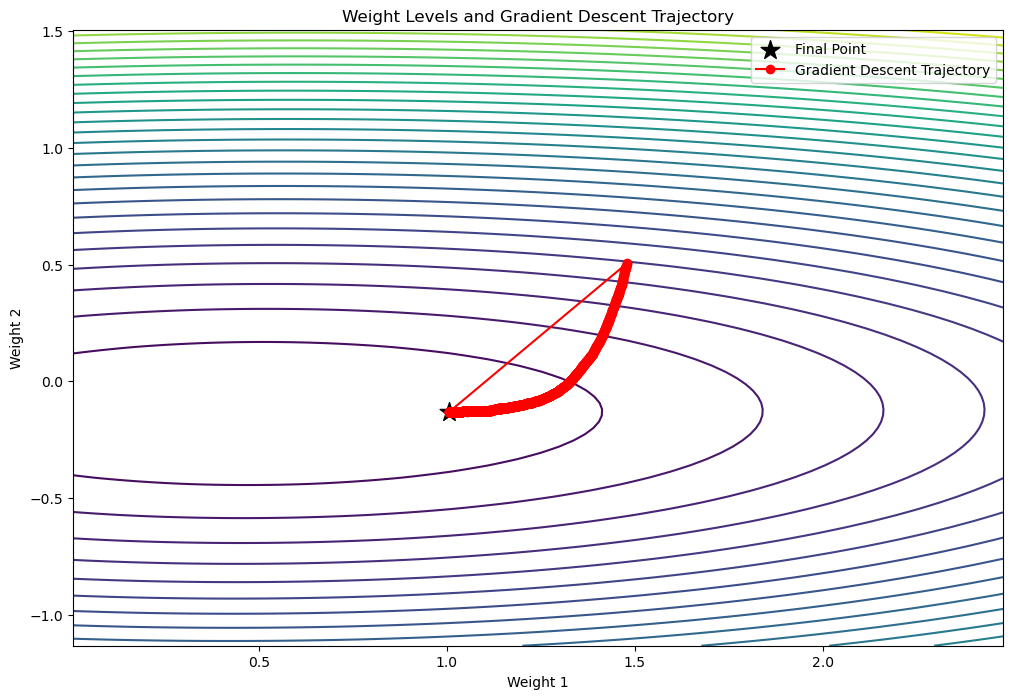

In [151]:
np.random.seed(42)
n, m = 5000, 2

w_true = np.random.standard_normal(m)

X = np.random.uniform(-5, 5, (n, m))
X *= (np.arange(m) * 2 + 1)[np.newaxis, :]

y = X.dot(w_true) + np.random.normal(0, 1, (n))

sgd_w, sgd_w_history, _ = stochastic_gradient_descent(epochs, batch_size, alpha, X, y, max_iters=max_iters)
plot_weight_levels(X, y, sgd_w_history)

#### SGD: Размерность 10000

[-0.71178415 -0.09774383]


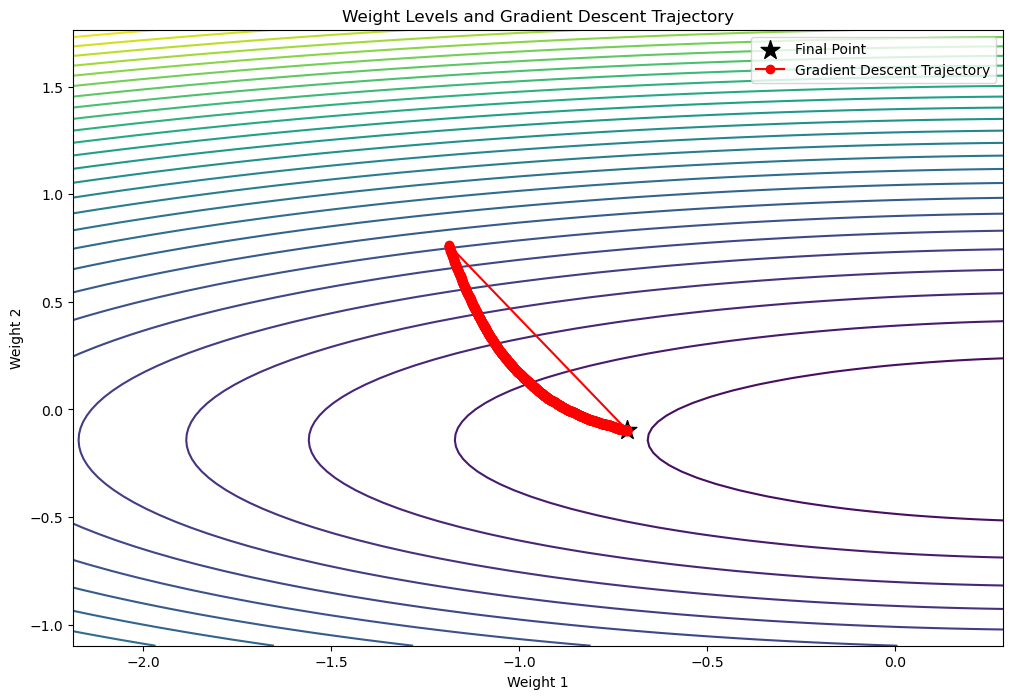

In [153]:
np.random.seed(42)
n, m = 10000, 2

w_true = np.random.standard_normal(m)

X = np.random.uniform(-5, 5, (n, m))
X *= (np.arange(m) * 2 + 1)[np.newaxis, :]

y = X.dot(w_true) + np.random.normal(0, 1, (n))

sgd_w, sgd_w_history, _ = stochastic_gradient_descent(epochs, batch_size, alpha, X, y, max_iters=max_iters)
plot_weight_levels(X, y, sgd_w_history)

#### Momentum: Размерность 5000

In [155]:
np.random.seed(42)
n, m = 5000, 2

w_true = np.random.standard_normal(m)

X = np.random.uniform(-5, 5, (n, m))
X *= (np.arange(m) * 2 + 1)[np.newaxis, :]

y = X.dot(w_true) + np.random.normal(0, 1, (n))

[ 0.49255576 -0.13983453]


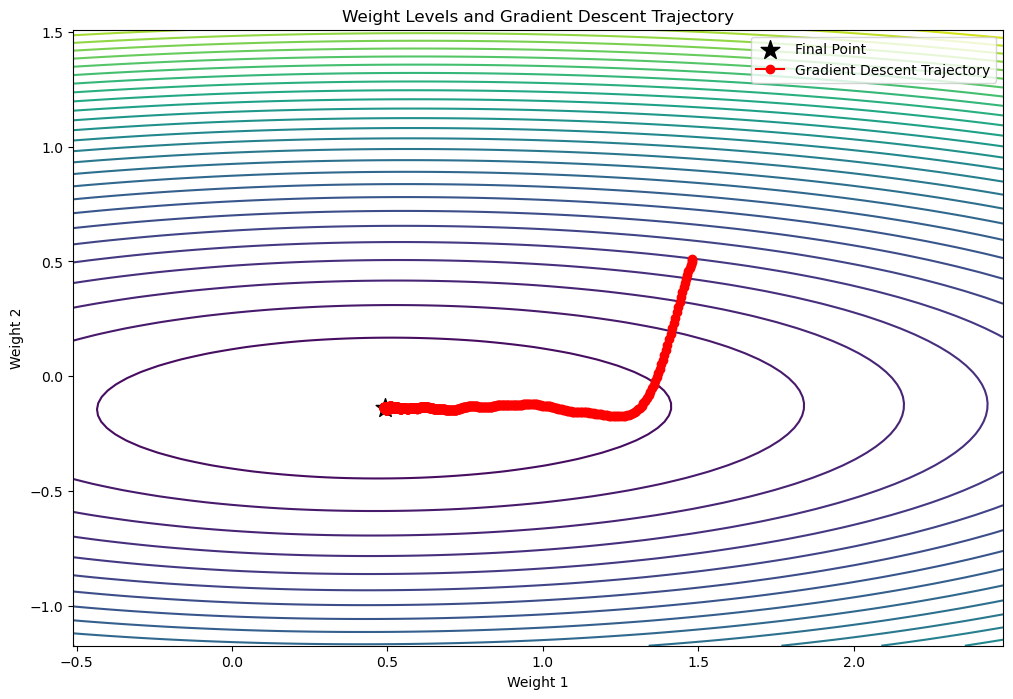

In [156]:
momentum_w, momentum_w_history, moment_err = stochastic_gradient_descent_momentum(
    epochs, batch_size, alpha, X, y, max_iters=max_iters
)
plot_weight_levels(X, y, momentum_w_history)

#### RMSprop: Размерность 5000

[ 0.48231403 -0.16104735]


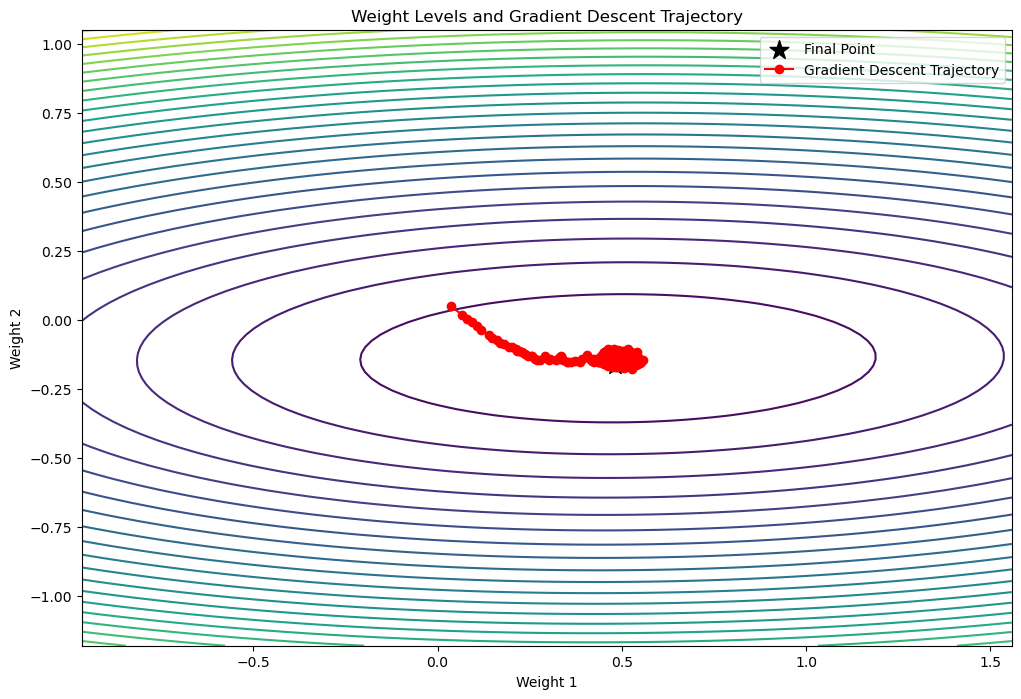

In [158]:
rmsprop_w, rmsprop_w_history, rmsprop_err = stochastic_gradient_descent_rmsprop(
    epochs, batch_size, alpha, X, y, max_iters=max_iters
)
plot_weight_levels(X, y, rmsprop_w_history)

#### Adam: Размерность 5000

[ 0.49757599 -0.14127967]


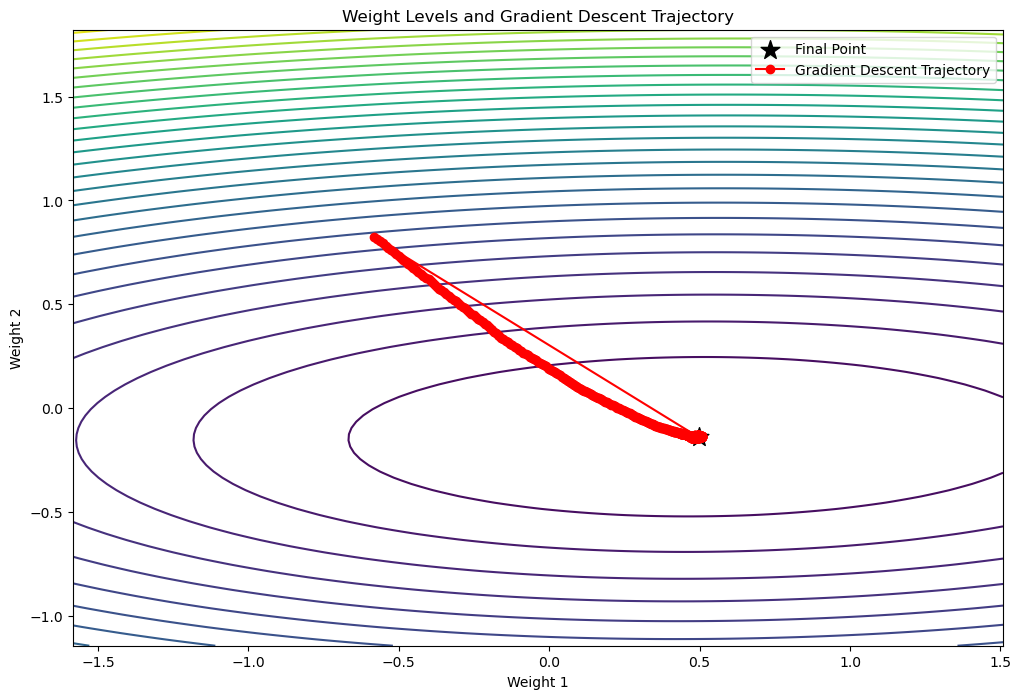

In [160]:
adam_w, adam_w_history, adam_err = adam_optimizer(
    epochs, batch_size, alpha, X, y, max_iters=max_iters
)
plot_weight_levels(X, y, adam_w_history)

In [161]:
np.random.seed(42)
w_init = np.random.standard_normal(X.shape[1])

# Запуск методов
w, w_history, err = gradient_descent(epochs, alpha, X, y)

sgd_w, sgd_w_history, sgd_err = stochastic_gradient_descent(
    epochs, batch_size, alpha, X, y
)

momentum_w, momentum_w_history, moment_err = stochastic_gradient_descent_momentum(
    epochs, batch_size, alpha, X, y, max_iters=max_iters
)

rmsprop_w, rmsprop_w_history, rmsprop_err = stochastic_gradient_descent_rmsprop(
    epochs, batch_size, alpha, X, y, max_iters=max_iters
)

adam_w, adam_w_history, adam_err = adam_optimizer(
    epochs, batch_size, alpha, X, y, max_iters=max_iters
)

[0.64768854 1.52302986]
[  0.68110674 248.23714551]
[ 0.52370629 -0.14078783]


In [162]:
# Затюним график

def plot_convergence(sgd_err, momentum_err, rmsprop_err, adam_err):
    """Функция для визуализации сходимости различных оптимизаторов."""
    plt.figure(figsize=(12, 6))

    plt.plot(abs(sgd_err), label='BaseLine SGD', color='blue', linewidth=1)
    plt.plot(abs(momentum_err), label='Momentum', color='red', linewidth=0.8)
    plt.plot(abs(rmsprop_err), label='RMSprop', color='green', linewidth=0.8)
    plt.plot(abs(adam_err), label='Adam', color='black', linewidth=0.8)

    plt.title('Convergence Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Error', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.show()

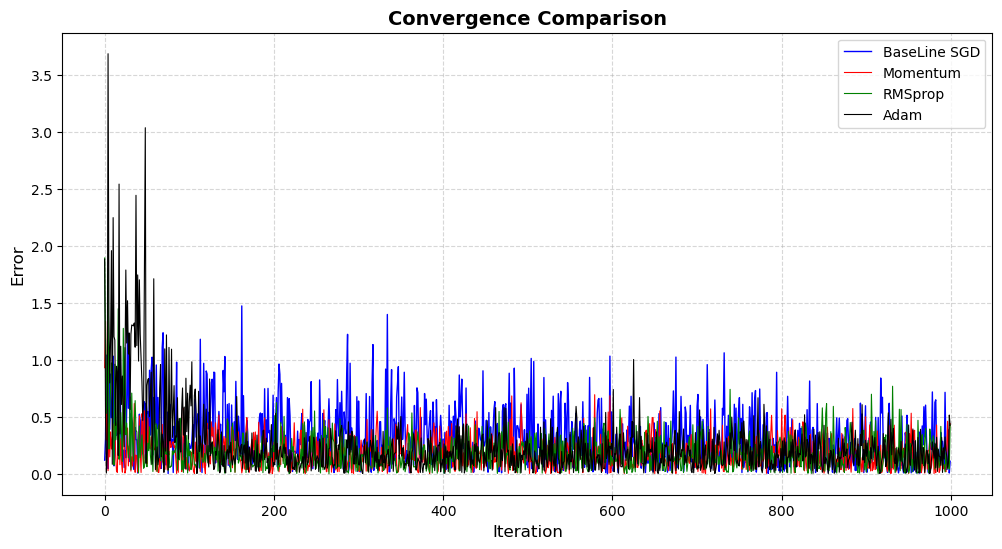

In [163]:
plot_convergence(sgd_err, moment_err, rmsprop_err, adam_err)

### Выводы

Судя по графику, можно сказать, что в контексте 1000 итераций наиболее хорошо себя показывает Adam. Начиная с заметных колебаний, алгоритм достаточно неплохо сходится к истинному минимуму.

RMSprop находит минимум, но зашумляется в нем (бродит вокруг минимума)

Momentum аналогично находит минимум.

А стохастический градиентный спуск застревает в мнимых (скорее, локальных) минимумах; полагаю, что требуется более тщательный подбор параметров размера батча и эпох. В принципе, отдельно поэксперементировал с объемом исходной выборки - по мере ее роста SGD показывает себя значительно хуже.
UPD.: если тюнить эпохи и батчи по мере роста выборки, вижу улучшения по сходимости (алгоритм даже достигает оптимума).